In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [77]:
def ternary_plot(data,
                 labels = ('R', 'P', 'S'),
                    sides = 3,
                    start_angle = 90,
                    fig_args = {'figsize':(18,18),'facecolor':'white','edgecolor':'white'},
                    edge_args = {'color':'black','linewidth':2},
                    rotate_labels = False,
                    label_offset = 0.10
):
    
    basis = np.array([
        [
            np.cos(2*x*np.pi/sides + start_angle*np.pi/180),
            np.sin(2*x*np.pi/sides + start_angle*np.pi/180)
        ] for x in range(sides)
    ])
    
    newdata = np.dot(data, basis)
    fig = plt.figure(**fig_args)
    ax = fig.add_subplot(111)
    
    for i,l in enumerate(labels):
        if i >= sides:
            break
        
        x = basis[i,0]
        y = basis[i,1]
        if rotate_labels:
            angle = 180 * np.arctan(y/x)/np.pi + 90
            if angle > 90 and angle <= 270:
                angle = np.mod(angle + 180, 360)
        else:
            angle = 0
        
        ax.text(
            x * (1 + label_offset),
            y * (1 + label_offset),
            l,
            horizontalalignment='center',
            verticalalignment='center',
            rotation=angle,
            size=34
        )
        
    # clear normal axes
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)
    
    # plot border
    ax.plot(
        [ basis[x,0] for x in list(range(sides)) + [0,] ],
        [ basis[x,1] for x in list(range(sides)) + [0,] ],
        **edge_args
    )
    
    # extra room for labels
    ax.set_xlim(left=-1.2, right=1.2)
    ax.set_ylim(bottom=-1.2, top=1.2)
    
    # plot
    end = len(newdata[:,0]) - 1
    for i in range(0,end):
        ax.plot(newdata[:,0][i:i+2], newdata[:,1][i:i+2], '.-', linewidth=2, alpha=0.99, c=(0, i / end, i / end))
    # ax.plot(newdata[:,0], newdata[:,1], linewidth=2, alpha=0.99, c='#00ff00')
    
    # fig.show()

In [80]:
def plot_file(filename, start=0, end=-1, sep=';', size=(18,5)):
    df = pd.read_csv(filename, sep=sep)
    
    if end < start:
        end = len(df)
    
    if start > 0 or end < len(df):
        df = df[start:end]
    
    df_avg = df[['Avg Rock', 'Avg Paper', 'Avg Scissor']]
    df_lod = df[['LOD Rock', 'LOD Paper', 'LOD Scissor']]
    df_best = df[['Best Rock', 'Best Paper', 'Best Scissor']]
    
    ternary_plot(df_avg)
    ternary_plot(df_lod)
    ternary_plot(df_best)
    
    lw = 2
    
    # average
    plt.figure(figsize=size)
    plt.plot(df['Generation'], df['Avg Rock'], color='grey', linewidth=lw, label='Rock')
    plt.plot(df['Generation'], df['Avg Paper'], color='green', linewidth=lw, label='Paper')
    plt.plot(df['Generation'], df['Avg Scissor'], color='orange', linewidth=lw, label='Scissor')

    plt.xlabel('Generation')
    plt.ylabel('Probability')
    plt.title('Average Strategy')
    plt.legend()
    plt.show()

#     # best
#     plt.figure(figsize=size)
#     plt.plot(df['Generation'], df['Best Rock'], color='grey', linewidth=lw, label='Rock')
#     plt.plot(df['Generation'], df['Best Paper'], color='green', linewidth=lw, label='Paper')
#     plt.plot(df['Generation'], df['Best Scissor'], color='orange', linewidth=lw, label='Scissor')

#     plt.xlabel('Generation')
#     plt.ylabel('Probability')
#     plt.title('Best Agent\'s Strategy')
#     plt.legend()
#     plt.show()

    # line of descent
    plt.figure(figsize=size)
    plt.plot(df['Generation'], df['LOD Rock'], color='grey', linewidth=lw, label='Rock')
    plt.plot(df['Generation'], df['LOD Paper'], color='green', linewidth=lw, label='Paper')
    plt.plot(df['Generation'], df['LOD Scissor'], color='orange', linewidth=lw, label='Scissor')

    plt.xlabel('Generation')
    plt.ylabel('Probability')
    plt.title('Line Of Descent')
    plt.legend()
    plt.show()

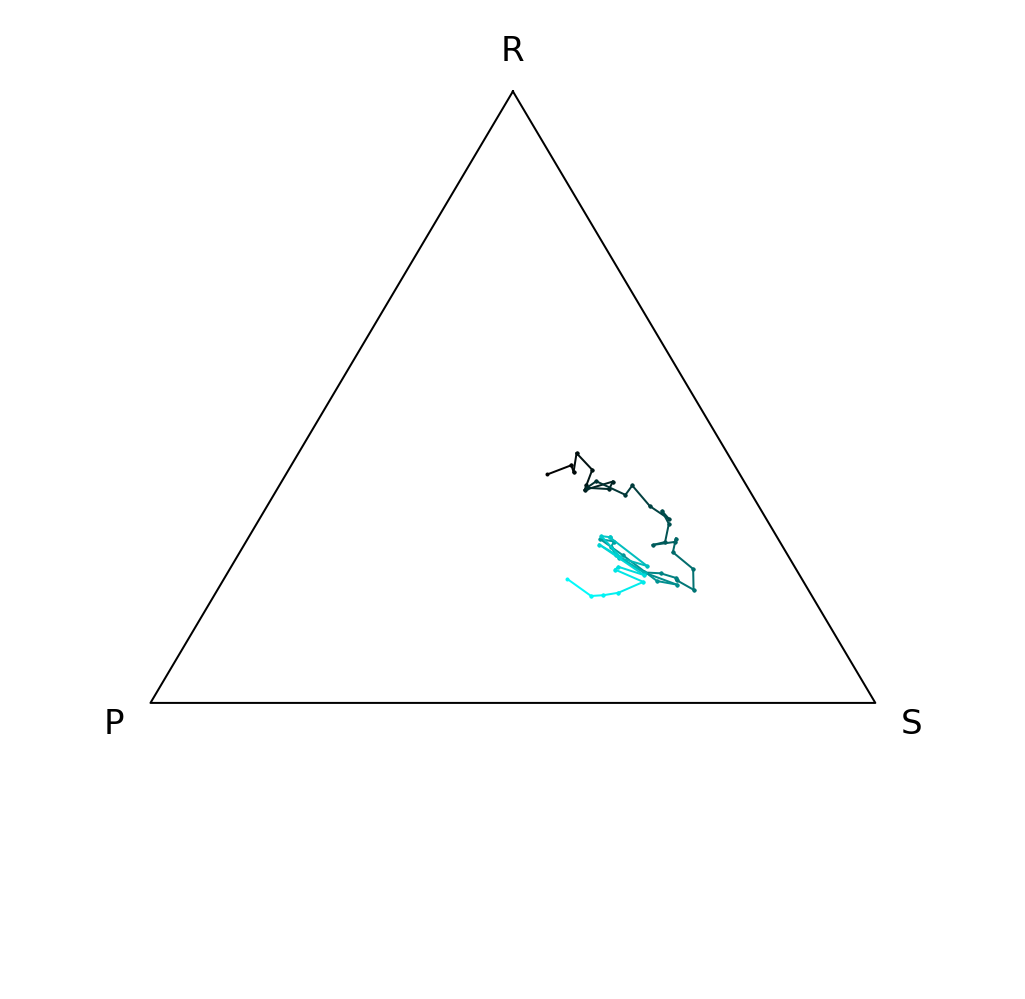

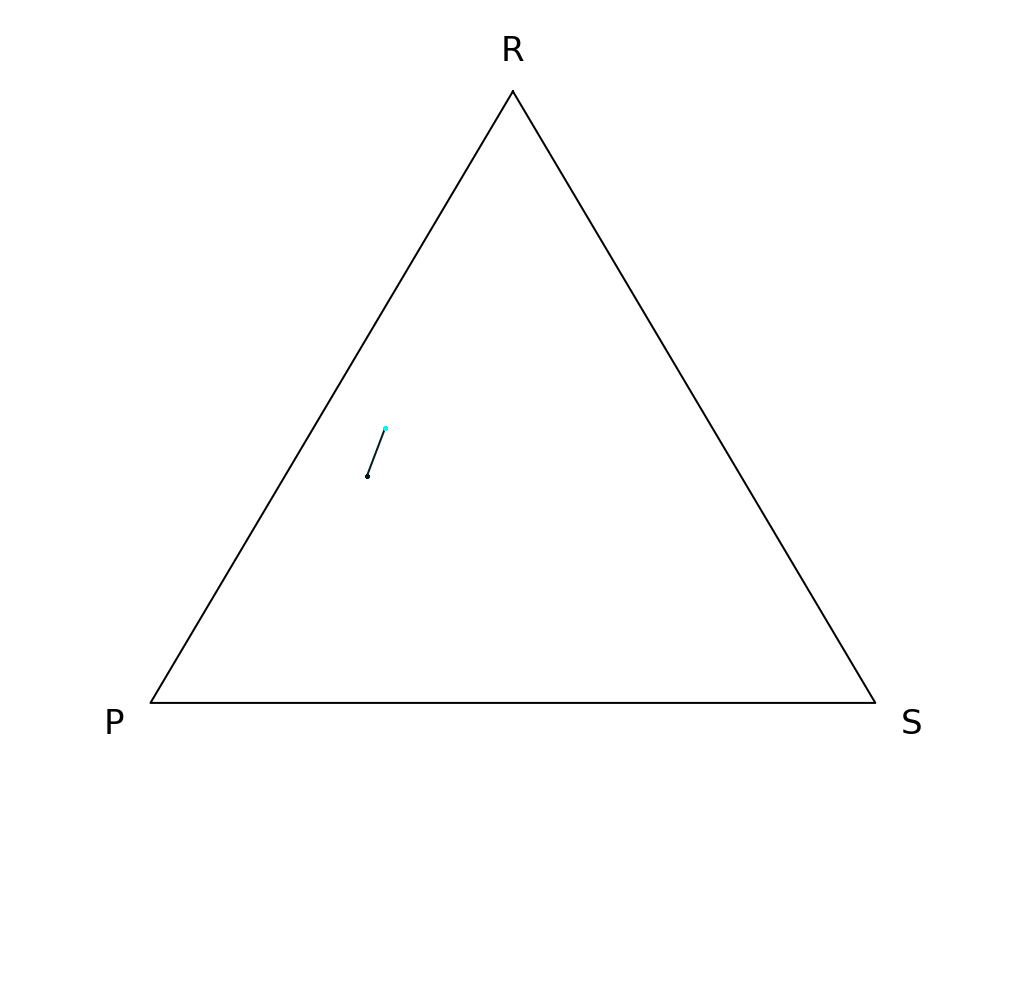

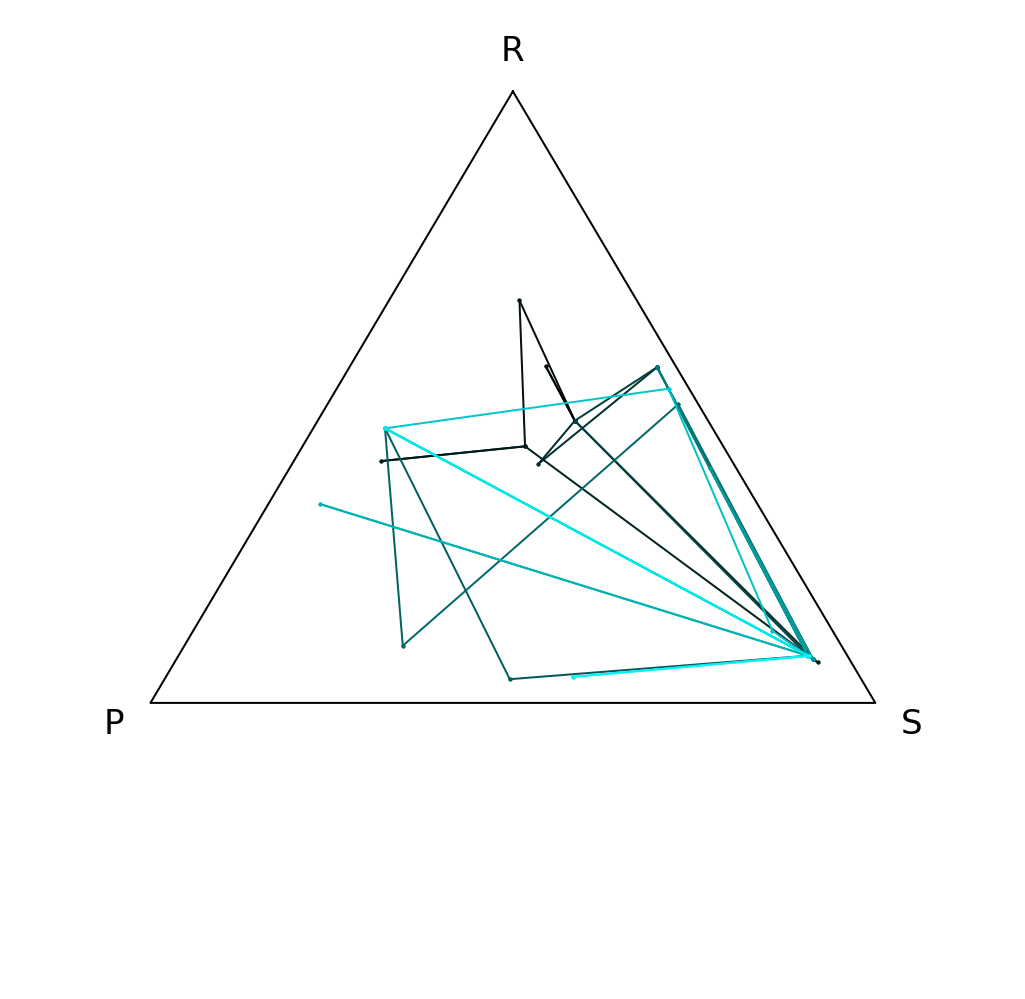

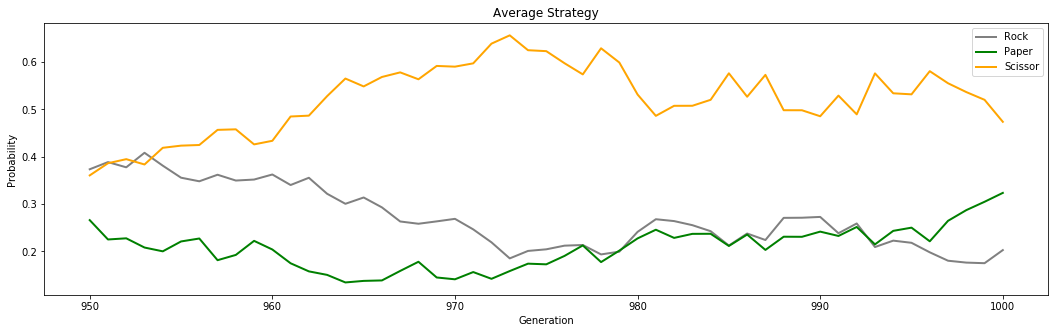

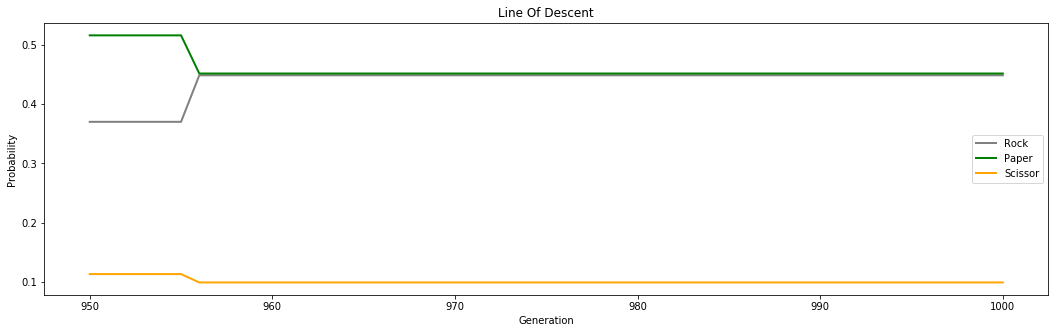

In [82]:
plot_file('csvs/gouber.csv', start=950)

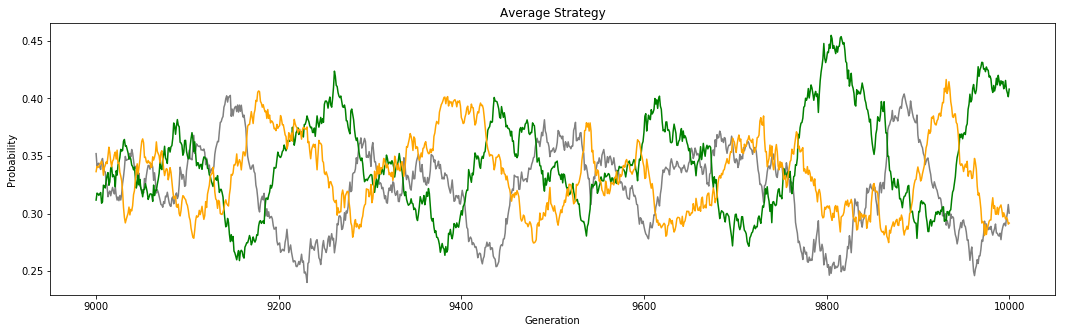

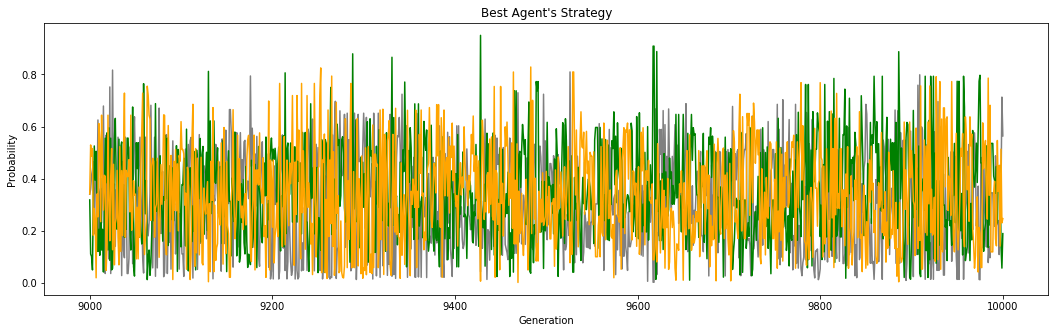

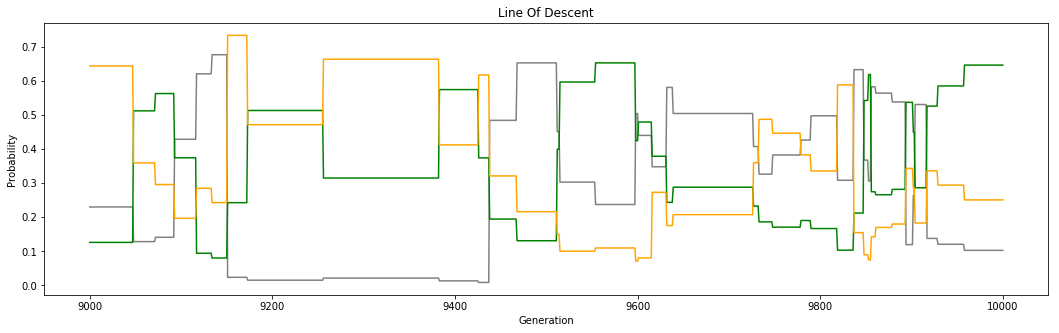

In [13]:
plot_file('largeres.csv', start=9000)